<a href="https://colab.research.google.com/github/sonudk/Source-Code-from-Tutorials/blob/master/190606_kerasbasics_gaussian_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras Basics
We will learn about
* Dense layers
* Categorical cross-entropy

A toy example to show how to train a classifier with Keras and use it. The data comes from three gaussian distributions.

In [0]:
## DATA GENERATION
import numpy as np

def generateX(cls):
    '''
    Inputs:
        cls: class {0, 1, 2}
    Outputs:
        a sample from cls
    '''
    assert cls in [0,1,2]
    if cls==0:
        return np.random.normal(np.array([0,0]),100)# what this means
    elif cls==1:
        return np.random.normal(np.array([200,200]),100)
    elif cls==2:
        return np.random.normal(np.array([-200,200]),100)
    assert False


Could you write a function to generate N samples from class 0 and N samples from class 1?

In [14]:
def generateXY(N):
    '''
    Inputs:
        N: no. of samples of each class
    '''
    Y = []
    X = []
    for cls in range(3):
        for i in range(N):
            y = cls
            x = generateX(y)
            x = x.reshape(-1, 1).T
            Y.append(y)
            X.append(x)
    X = np.concatenate(X, axis=0)
    print(X.shape, 'X.shape')
    print(np.array(Y).shape)
    Y = np.array(Y).reshape(-1,1)
    print(X.shape)
    print(Y.shape)
    return X, Y

# def generateXY(N):
#     '''
#     Inputs:
#         N: no. of samples of each class
#     '''
#     Y = [0]*N + [1]*N + [2]*N   # a list of 0s and 1s as ground truth classes  
#     X = [generateX(y) for y in Y]  # samples corresponding to the ground truth Y
#     X = np.vstack(X)   # arrange samples in different rows
#     Y = np.array(Y).reshape(-1,1)
#     return X, Y

X_train, Y_train_int = generateXY(50)
# Nx = X_train.shape
print(Y_train_int)

(150, 2) X.shape
(150,)
(150, 2)
(150, 1)
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]]


In [5]:
def test_generateXY():
    X_train, Y_train = generateXY(50)
    assert X_train.shape==(150,2)
    assert Y_train.shape==(150,1)
    print("OK")
test_generateXY()

(150, 2) X.shape
(150,)
(150, 2)
(150, 1)
OK


### One-hot encoding

Now our Y is in the form [0], [1] and [2]. We want to convert them to [1,0,0], [0,1,0] and [0,0,1], respectively. 
Could you write a code to convert Y (with one column) into one-hot encoded Y (with 3 columns)?

In [0]:
def oneHot(y, Ny):
    '''
    Input:
        y: an int in {0, 1, 2}
        Ny: Number of classes, e.g., 3 here.
    Output:
        Y: a vector of Ny (=3) tuples
    '''
    Y = np.zeros(Ny)
    Y[y] = 1
    return Y

Ny = 3
Y_train = np.array([oneHot(y,Ny) for y in Y_train_int])

In [7]:
def test_oneHot():
    assert np.all(oneHot(0,3)==np.array([1,0,0]))
    assert np.all(oneHot(1,3)==np.array([0,1,0]))
    assert np.all(oneHot(2,3)==np.array([0,0,1]))
    assert Y_train.shape[1]==3
    print("OK")
test_oneHot()

OK


### Input Normalization
X can lie in any unbounded range. We need to curtail to a narrow range close to zero. This helps in enhancing the stability of training and hyper-parameter tuning.
This is normally achieved by scaling the X to have zero mean and unit standard deviation (std).

$X \leftarrow \frac{X-mean(X)}{std(X)}$, where this is element wise division

Could you use training samples to find mean and std, and normalize your X_train with that?

In [0]:

def findMeanStddev(X):
    '''
    Input: 
        X: a matrix of size (no. of samples, dimension of each sample)
    Output:
        mean: mean of samples in X (same size as X)
        stddev: element-wise std dev of sample in X (same size as X)
    '''
    mean = np.sum(X, axis=0)/X.shape[0]
    X1 = X-mean
    stddev = np.sqrt(np.sum(X1*X1, axis=0)/X.shape[0])
    return mean, stddev

def normalizeX(X, mean, stddev):
    '''
    Input:
        X: a matrix of size (no. of samples, dimension of each sample)
        mean: mean of samples in X (same size as X)
        stddev: element-wise std dev of sample in X (same size as X) 
    Output:
        Xn: X modified to have 0 mean and 1 std dev
    '''
    Xn = (X-mean)/(stddev+1e-8)
    return Xn

mean_train, stddev_train = findMeanStddev(X_train)
X_train = normalizeX(X_train, mean_train, stddev_train)

In [9]:
def test_normalizeX():
    X = np.ones((3,3))
    m,s = findMeanStddev(X)
    assert np.all(m==np.ones(3))
    assert np.all(s==np.zeros(3))
    assert np.all(normalizeX(X,m,s)==0*X)
    assert mean_train.shape==(2,)
    assert stddev_train.shape==(2,)
    # test on random X
    X = np.random.random((5,3))
    m,s = findMeanStddev(X)
    Xn = normalizeX(X,m,s)
    mn, sn = findMeanStddev(Xn)
    assert np.allclose(mn, np.zeros(3))
    assert np.allclose(sn, np.ones(3))
    print("OK")
test_normalizeX()

OK


### Plotting
Could you plot all the samples in X_train with different colors for different classes?

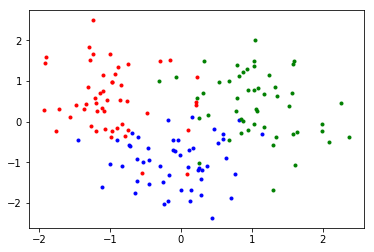

In [11]:
import matplotlib.pyplot as plt
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
def plotXY(X, Y):
    '''
    Inputs:
        X: a matrix of size (no. of samples, dimension of each sample)
        Y: a matrix of size (no. of samples, no. of classes) - these are one-hot vectors
    Action:
        Plots the samples in X, their color depends on Y
    '''
    Ny = Y.shape[1]
    for cls in range(Ny):
        idx = np.where(Y[:,cls]==1)[0]
        plt.plot(X[idx,0], X[idx,1], colors[cls]+'.')
    plt.show()
plotXY(X_train, Y_train)

## Creating the Network
We now create the network with dense layers: 
$y = f(Wx)$

ReLU activation: 
$f(h) = h, h>0; 0, h\le 0$

Softmax activation: 
$f(h_i) = \frac{\exp(h_i)}{\sum_j \exp(h_j)}$

Categorical cross-entropy loss:
$\mathcal{L} = -\sum_t y^d_t \log y_t$

Stochastic Gradient Descent:
$w_{ij} \leftarrow w_{ij} - \eta \frac{\partial \mathcal{L}}{\partial w_{ij}}$

In [0]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

x = Input(shape=(Nx,))
y = Dense(20, activation='relu')(x)
y = Dense(Ny, activation='softmax')(y)
model = Model(inputs=x, outputs=y)
model.compile(optimizer=optimizers.sgd(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


### Plotting the model

In [16]:
from keras.utils import plot_model
def plotModel(model):
    plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
    from IPython.display import Image
    Image(retina=True, filename='model.png')

Using TensorFlow backend.


### Training


In [0]:
history = model.fit(X_train, Y_train, epochs=50) # validation_split = 0.1

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
150/150 [==============================] - 1s 5ms/step - loss: 0.5571 - acc: 0.8267
Epoch 2/50
150/150 [==============================] - 0s 144us/step - loss: 0.5452 - acc: 0.8267
Epoch 3/50
150/150 [==============================] - 0s 151us/step - loss: 0.5325 - acc: 0.8267
Epoch 4/50
150/150 [==============================] - 0s 136us/step - loss: 0.5213 - acc: 0.8267
Epoch 5/50
150/150 [==============================] - 0s 149us/step - loss: 0.5104 - acc: 0.8267
Epoch 6/50
150/150 [==============================] - 0s 149us/step - loss: 0.4992 - acc: 0.8267
Epoch 7/50
150/150 [==============================] - 0s 176us/step - loss: 0.4894 - acc: 0.8267
Epoch 8/50
150/150 [==============================] - 0s 162us/step - loss: 0.4806 - acc: 0.8267
Epoch 9/50
150/150 [==============================] - 0s 169us/step - loss: 0.4715 - acc: 0.8267
Epoch 10/50
150/150 [==============================] - 0s 370us/step - loss: 0.46

### Evaluation
Could you:
- Generate 20 samples from each class
- Normalize them with mean_train and std_train
- Get Y_test as one hot encoded labels

In [0]:
X_test, Y_test_int = generateXY(20)
X_test = normalizeX(X_test, mean_train, stddev_train)
Y_test = np.array([oneHot(y,Ny) for y in Y_test_int])

In [0]:
def test_testData():
    assert Y_test.shape==(60,3)
    assert X_test.shape==(60,2)
#     mn, sn = findMeanStddev(X_test)
#     assert np.allclose(mn, np.zeros(2), atol=1)
#     assert np.allclose(sn, np.ones(2), atol=1)
    print("OK")
test_testData()

OK


In [0]:
## Evaluation
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)  # Evaluate the model
print('Accuracy :%0.3f'%accuracy)
Y_pred = model.predict(X_test)
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print( confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) )

Accuracy :0.867
[[13  3  4]
 [ 1 19  0]
 [ 0  0 20]]
